# EarthMoonSystem.ipynb

## This notebook sets up some parameters for the Earth/Moon Planar Circular Restricted Three-Body Problem (PCR3BP), finds the Lagrange points, plots the effective potential contours, and solves the CR3BP ODE's to generate a trajectory.

In [1]:
using ThreeBodyProblem
using DifferentialEquations
using Plots

┌ Info: Precompiling ThreeBodyProblem [f5e9ba3c-56cf-4230-8a8f-3a70500a02a9]
└ @ Base loading.jl:1317


In [2]:
gr() # This command sets GR as our plotting backend

Plots.GRBackend()

## When declaring variables, I like to add a comment with the units in curly brackets as well as a description

In [3]:
μ₁ = 398600 # {km³/s²} gravitational parameter of Earth
μ₂ = 4902   # {km³/s²} gravitational parameter of the Moon
d = 384400  # {km} average distance between Earth and the Moon

384400

In [4]:
p = [μ₁, μ₂, d] # concatenate the parameters into one array

3-element Vector{Int64}:
 398600
   4902
 384400

## Now we plug this parameter array into some functions to calculate the location of L1

In [6]:
L1 = computeL1(p) # calculate the Lagrange point L1 for the given system parameters p

3-element Vector{Float64}:
 321713.8570517506
      0.0
      0.0

## You can calculate all the Lagrange points and just select the one you're interested in

In [8]:
Lpts = computeLpts(p)
L4 = Lpts[4]

3-element Vector{Float64}:
 187530.06329584488
 332900.16521473817
      0.0

In [10]:
R₁,R₂ = computeR1R2(p) # {km} distances of Primary and Secondary bodies from origin

(4669.936704155122, 379730.0632958449)

In [11]:
ωₛ = sqrt((μ₁ + μ₂)/d^3) # {rad/s} rotation rate of system

2.665310298373478e-6

## Here we set up a mesh grid of 100 points centered at the origin

In [12]:
N = 100
X = range(-1.5*d,1.5*d,length=N)
Y = range(-d,d,length=N)

-384400.0:7765.656565656565:384400.0

In [13]:
gr()
f(x,y) = begin
    -(x^2 + y^2)*ωₛ^2/2 - μ₁/sqrt((x+R₁)^2 + y^2) - μ₂/sqrt((x-R₂)^2 + y^2)
    # rv = [x; y; 0; 0; 0; 0]
    # findUeff(rv,p)
end
contour(X,Y,f,levels=200,fill=true)

## Some more parameters describing our system

In [14]:
Rₑ = 6378.0 # {km} radius of the Earth
Rₘ = 1738.0 # {km} radius of the Moon

1738.0

## Here we define the initial conditions of our injection orbit

In [15]:
h = 200.0           # {km} altitude of parking orbit
vᵢ = 10.92367104    # {km/s} injection velocity in rotating frame
ϕ = 47.70061087     # {°} injection angle, measured from +y

47.70061087

In [16]:
r₀ = [-R₁ - (Rₑ + 200)*cosd(ϕ); -(Rₑ + 200)*sind(ϕ); 0]
v₀ = vᵢ*[sind(ϕ); -cosd(ϕ); 0];
rv₀ = [r₀;v₀] # {km; km/s} our initial state 

6-element Vector{Float64}:
 -9096.961145507787
 -4865.340542620438
     0.0
     8.07956515432666
    -7.3516811619605145
     0.0

## Make sure to use float values rather than integers (e.g. 0. instead of 0) when setting up the timespan for the solver.

In [17]:
tspan = (0.,86400*6.) # {sec} 6 day span

(0.0, 518400.0)

## Here we set up our ODE and solve it

In [18]:
prob = ODEProblem(CR3BPdynamics!,rv₀,tspan,p) # CR3BPdynamics! is our in-place dynamics function
sol = solve(prob,reltol=1e-6)

retcode: Success
Interpolation: automatic order switching interpolation
t: 110-element Vector{Float64}:
      0.0
      0.1980906955674927
      2.17899765124242
     21.988067207991687
     92.77548737077912
    196.70550680692864
    313.66493622131645
    448.2393711506835
    597.2054620073549
    763.4105644878707
    948.2719029353584
   1155.811732189169
   1390.2111998629775
      ⋮
 502204.5225481493
 502776.46720414114
 503450.86268056574
 504247.17984168907
 505193.9763025849
 506321.74903279514
 507669.1114874278
 509281.41010562645
 511214.1113189282
 513532.78392863704
 516292.6302608812
 518400.0
u: 110-element Vector{Vector{Float64}}:
 [-9096.961145507787, -4865.340542620438, 0.0, 8.07956515432666, -7.3516811619605145, 0.0]
 [-9095.360537973598, -4866.796709407592, 0.0, 8.080785257845982, -7.350339812191332, 0.0]
 [-9079.341186525837, -4881.34374796782, 0.0, 8.092961893716812, -7.336904230035766, 0.0]
 [-8917.838222786235, -5025.335334766077, 0.0, 8.212236092081602, -7.

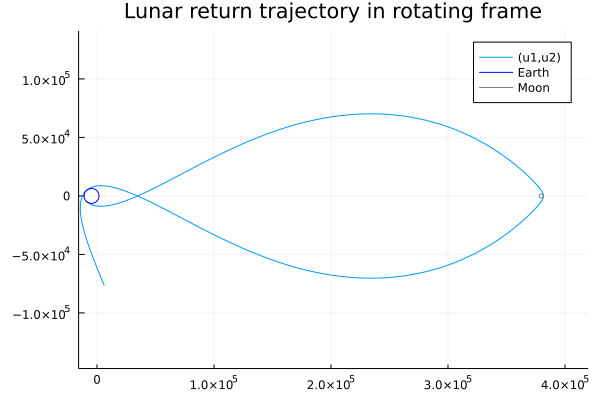

In [21]:
plot(sol,vars=(1,2),title="Lunar return trajectory in rotating frame")
plot!(circle(Rₑ,[-R₁;0]),color="blue",label="Earth")
plot!(circle(Rₘ,[R₂;0]),color="gray",label="Moon",aspect_ratio=:equal)

## We can convert to the inertial frame and plot

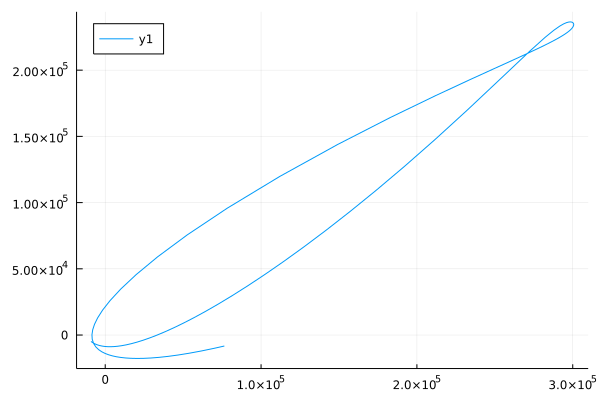

In [27]:
rv_inert = [rot2inert(sol.u[i],sol.t[i],p) for i = 1:length(sol)]
x = [rv_inert[i][1] for i = 1:length(rv_inert)]
y = [rv_inert[i][2] for i = 1:length(rv_inert)]
plot(x,y,legend=:topleft)

## All done!